# Time-series Forecasting

## Description
The data consists of 52,416 observations of energy consumption on a 10-minute window. Every observation is described by the following feature columns.

Your task is to **aggregate the observations on an interval of 1 hour**. For this time interval, using the values of the **6 previous time intervals**, forecast the target value one step in the future. Choose which features you are going to use.

**You must train an LSTM network.**



Features:

* TimePeriod: Time window of ten minutes.
* WT: Weather Temperature.
* WH: Weather Humidity.
* WS: Wind Speed.
* GDF: General Diffuse Flow. “Diffuse flow” is a catchall term to describe low-temperature (< 0.2° to ~ 100°C) fluids that slowly discharge through sulfide mounds, fractured lava flows, and assemblages of bacterial mats and macrofauna.
* DF: DiffuseFlows

Target:

Consumption

## Dateset links:
 * [DS1](https://drive.google.com/file/d/1-8neeIpiq6yzWVw4EG_WgzHX4kPH1n1j/view?usp=sharing)
 * [DS2](https://drive.google.com/file/d/1-LhrUaH59q8O0SYB8WE-Eov2gaTMQYVx/view?usp=sharing)

## Read the datasets

In [ ]:
import pandas as pd

In [ ]:
data1 = pd.read_csv('/content/power_consumption_g2.csv')
data1.head(3)

,TimePeriod,Consumption
0,2017-12-02 20:10:00,36824.33460
1,2017-12-25 15:30:00,31841.82510
2,2017-05-19 21:10:00,44909.11475


In [ ]:
data2 = pd.read_csv('/content/power_consumption_g2_feat.csv')
data2.head(3)

,TimePeriod,WT,WH,WS,GDF,DF
0,2017-03-01 16:40:00,21.33,55.91,0.080,387.400,427.300
1,2017-07-27 06:30:00,23.10,48.58,4.908,10.450,8.630
2,2017-10-11 19:00:00,23.10,59.82,0.084,0.446,0.322


## Merge the datasets (and pre-process if needed)

In [ ]:
data = pd.merge(data1, data2, on='TimePeriod')
data.head(10)

,TimePeriod,Consumption,WT,WH,WS,GDF,DF
0,2017-12-02 20:10:00,36824.33460,15.90,62.15,0.082,0.059,0.126
1,2017-12-25 15:30:00,31841.82510,17.90,45.94,0.090,327.500,61.470
2,2017-05-19 21:10:00,44909.11475,19.70,84.70,0.070,0.040,0.089
3,2017-05-28 04:50:00,22964.45902,19.31,79.90,0.073,0.051,0.104
4,2017-05-08 16:10:00,33829.77049,23.52,51.28,0.071,674.800,708.000
5,2017-05-20 00:30:00,28516.72131,18.09,88.00,0.068,0.051,0.130
6,2017-12-05 12:20:00,32212.92776,14.43,72.30,0.083,489.900,36.420
7,2017-01-29 13:20:00,32384.81013,17.71,49.12,4.914,564.500,70.800
8,2017-11-22 16:40:00,31790.76923,15.48,49.48,4.921,49.680,50.200
9,2017-03-24 23:40:00,31557.44681,12.84,55.64,0.087,0.055,0.111


In [ ]:
data['TimePeriod'] = pd.to_datetime(data['TimePeriod'])
data = data.set_index('TimePeriod')
data = data.sort_index()

## Group the datasets into time intervals of 1 hour

## Create lags

In [ ]:
data.columns

Index(['Consumption', 'WT', 'WH', 'WS', 'GDF', 'DF'], dtype='object')

In [ ]:
col_features = ['WT', 'WH', 'WS', 'GDF', 'DF', 'Consumption']
lag = 6
for i in range(1, lag+1):
  for col in col_features:
    data[f'{col}_prev_{i}'] = data[col].shift(i)

In [ ]:
data = data.dropna(axis=0)
data.columns

Index(['Consumption', 'WT', 'WH', 'WS', 'GDF', 'DF', 'WT_prev_1', 'WH_prev_1',
       'WS_prev_1', 'GDF_prev_1', 'DF_prev_1', 'Consumption_prev_1',
       'WT_prev_2', 'WH_prev_2', 'WS_prev_2', 'GDF_prev_2', 'DF_prev_2',
       'Consumption_prev_2', 'WT_prev_3', 'WH_prev_3', 'WS_prev_3',
       'GDF_prev_3', 'DF_prev_3', 'Consumption_prev_3', 'WT_prev_4',
       'WH_prev_4', 'WS_prev_4', 'GDF_prev_4', 'DF_prev_4',
       'Consumption_prev_4', 'WT_prev_5', 'WH_prev_5', 'WS_prev_5',
       'GDF_prev_5', 'DF_prev_5', 'Consumption_prev_5', 'WT_prev_6',
       'WH_prev_6', 'WS_prev_6', 'GDF_prev_6', 'DF_prev_6',
       'Consumption_prev_6'],
      dtype='object')

# Split the dataset into 80% training and 20% testing datasets

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
x, y = data.drop(columns=['Consumption', 'WT', 'WH', 'WS', 'GDF', 'DF']), data['Consumption']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

## Create the model, pre-process the data and make it suitable for training

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = scaler.fit_transform(y_train.values.reshape(-1,1))

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
x_train = x_train.reshape(x_train.shape[0], lag, x_train.shape[1] // lag)
x_test = x_test.reshape(x_test.shape[0], lag, x_test.shape[1] // lag)

In [ ]:
model = Sequential()
model.add(LSTM(128,  activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(LSTM(64,  activation='relu', return_sequences=True))
model.add(LSTM(16,  activation='relu'))
model.add(Dense(1, activation='linear'))

## Train the model, use 20% of the training dataset for validation
Train with 10 epochs (due to time limit)

In [ ]:
model.compile(loss=keras.losses.MeanSquaredError() , optimizer=keras.optimizers.Adam(), metrics=[keras.metrics.MeanSquaredError(), keras.metrics.MeanAbsoluteError()])

In [ ]:
history = model.fit(x_train, y_train, validation_split=0.2, batch_size=16, epochs=3, shuffle=False)

Epoch 1/3
1487/1487 [==============================] - 39s 21ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0448 - val_loss: 0.0019 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0320
Epoch 2/3
1487/1487 [==============================] - 21s 14ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0280 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0249
Epoch 3/3
1487/1487 [==============================] - 36s 24ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0248 - val_loss: 6.5799e-04 - val_mean_squared_error: 6.5799e-04 - val_mean_absolute_error: 0.0189


## Plot the loss function on the training and validation dataset

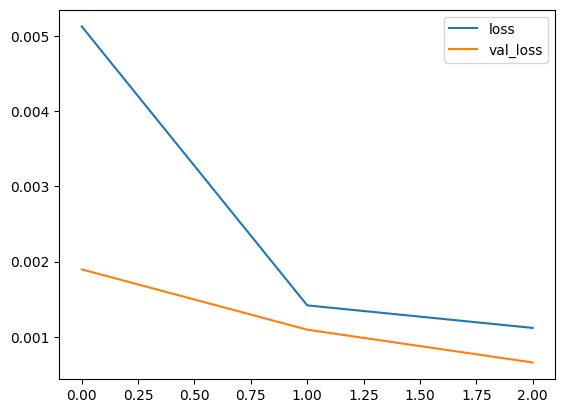

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## Calculate the adequate metrics

In [ ]:
preds = model.predict(x_test)
preds = scaler.inverse_transform(preds)

233/233 [==============================] - 2s 6ms/step


## Visualize the targets against the predictions

In [ ]:
mean_squared_error(y_test, preds), mean_absolute_error(y_test, preds), r2_score(y_test, preds)

(1907240.7854052393, 1162.5467503295667, 0.9501749608343837)

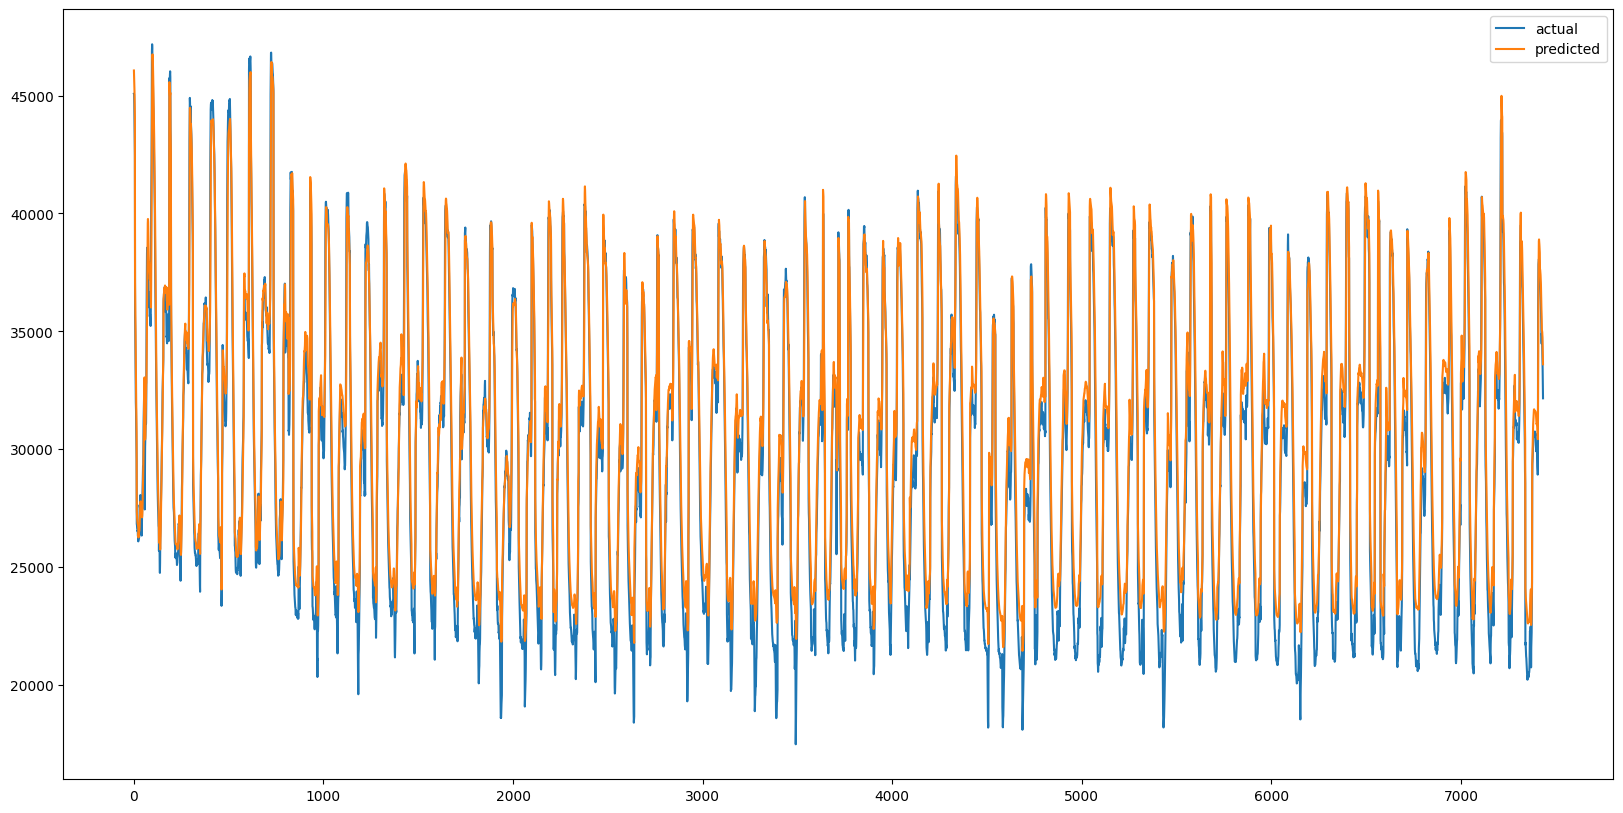

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(y_test.values, label='actual')
plt.plot(preds, label='predicted')
plt.legend()
plt.show()